# Inner Ambulatory EGG Report - Subject Specific
## Todd P. Coleman

The purpose of this notebook is to analyze ambulatory EGG recordings.
This notebook assumes that an "RID_list" has already been specified in the outer notebook.  For the purpose of debugging, you can uncomment where it says "RID_list = ['W180918-152239-Z1']"


In [1]:
import numpy as np
import scipy as sp
import scipy.io
from scipy.ndimage import gaussian_filter
from scipy import signal
import pandas as pd
pd.set_option('display.max_colwidth', -1,'display.max_rows',999)
import time, datetime, sys, os
# import ECG

# import ipympl
import matplotlib.pyplot as plt
#%matplotlib ipympl
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import seaborn as sns
sns.set(rc={'image.cmap': 'jet'},style="ticks",font_scale=1.2)


# directory containing HRVfreq.py
sys.path.append("../../ECGanalytics/")
from HRVfreq import *


## Experimental Protocol

Multichannel data was recorded with the OpenBCI amplifier at a sampling frequency of 250Hz.

## Import Data

In [2]:
directory = '../../colemanlab/internal/EGGMonitoring/data/Wearable/'
# RID_list = ['W180918-152239-Z1']
#RID_list = ['W161014-145305-L1','W161014-213925-L1','W161015-075336-L1']
#RID_list = ['W180607-104729-L1', 'W180608-074523-L1']
#RID_list = ['W180202-120300-U1']
#RID_list = ['W161220-114524-L1']
# RID_list = ['W180301-101451-X1']

In [3]:
dataEGG=[];dataEGGRaw=[];dataAccel=[];rECG=[];
for ii in range(0,len(RID_list)):
    RID = RID_list[ii]
    experimentData = directory + RID + '/' + RID + '-processed.mat'
    data = sp.io.loadmat(experimentData,squeeze_me=1)
    # add an extra channel of all zeros (reference)
    if data['expRef'] > 0:
        data['dataEGG'] = np.hstack((data['dataEGG'][:,0:data['expRef']-1],
                                     np.zeros([data['dataEGG'].shape[0],1]),
                                     data['dataEGG'][:,data['expRef']-1:]))
    dataEGG.append(data['dataEGG'])
    dataEGGRaw.append(np.copy(dataEGG))
    fsEGG = data['fsEGG']     
    dataAccel.append(data['dataAccel'])
    fsAccel = data['fsAccel']
    rECG.append(data['rECG'])
    
#START AND STOP TIMES
#extract start and stop times
dtStart=[]
dtStop=[]
for ii in range(0,len(RID_list)):
    dtStart.append(pd.to_datetime((str(int(RID_list[ii][3:5]))+'/'+str(int(RID_list[ii][5:7]))+'/20'+RID_list[ii][1:3]
                          +' '+str(int(RID_list[ii][8:10]))+':'+RID_list[ii][10:12]+':'+RID_list[ii][12:14])))
    dtStop.append(dtStart[ii]+datetime.timedelta(seconds=dataEGG[ii].shape[0]/fsEGG))

#### Combine Consecutive Recordings

In [4]:
#calculate number of zeros to append in between recordings
secondsAdd = []
for ii in range(1,len(dtStart)):
    secondsAdd.append((dtStart[ii]-dtStop[ii-1]).total_seconds())

for ii in range(0,len(secondsAdd)):
    if secondsAdd[ii]<0:
        print('WARNING: recording and log mismatch')
        secondsAdd[ii] = 0
    dataEGG.insert(ii*2+1,np.zeros((int(secondsAdd[ii]*fsEGG),dataEGG[0].shape[1])))
    dataAccel.insert(ii*2+1,np.zeros((int(secondsAdd[ii]*fsAccel),3)))
    rECG[ii+1][0,:]+=np.cumsum(np.diff(dtStart))[ii].total_seconds()

dataEGG = np.concatenate(dataEGG)
dataEGGRaw = np.copy(dataEGG)
dataAccel = np.concatenate(dataAccel)    
rECG = np.hstack(rECG)
    
#filter accelerometer
dataAccel = signal.decimate(dataAccel,int(fsAccel//1),n=299,ftype='fir',axis=0,zero_phase = True)
fsAccel = 1
b = signal.firwin(299,0.2,nyq=0.5*fsAccel,window=('kaiser',6.0),pass_zero=False)
dataAccel2 = signal.filtfilt(b,[1],x=dataAccel,axis=0)
dataAccel2 = np.sqrt(dataAccel2[:,0]**2+dataAccel2[:,1]**2+dataAccel2[:,2]**2)

## Import Log

In [5]:
eventTable = []
for ii in range(0,len(RID_list)):
    RID = RID_list[ii]
    eventData = directory + RID + '/' + RID + '-events.csv'
    eventTable.append(pd.read_csv(eventData))

eventTable = pd.concat(eventTable)
eventTable = eventTable.drop_duplicates(keep='first', inplace=False)
eventTable = eventTable.reset_index(drop=True)

dtEvents = pd.to_datetime(np.array(eventTable['Timestamp']))
#EVENT TYPES
eventType = np.zeros(len(dtEvents))
for ii in range(0,eventType.size):
    if eventTable['Event Type'][ii]=='I just started to record': eventType[ii]=1
    if eventTable['Event Type'][ii]=='I just woke up': eventType[ii]=2
    if eventTable['Event Type'][ii]=='I just ate a meal': eventType[ii]=3
    if eventTable['Event Type'][ii]=='I just ate a snack': eventType[ii]=4
    if eventTable['Event Type'][ii]=='I just had a bowel movement': eventType[ii]=5
    if eventTable['Event Type'][ii]=='I\'m having symptoms': eventType[ii]=6
    if eventTable['Event Type'][ii]=='I\'m going to sleep soon': eventType[ii]=7
    if eventTable['Event Type'][ii]=='I just stopped recording': eventType[ii]=8
    if eventTable['Event Type'][ii]=='Other': eventType[ii]=9
        
#remove sleep stop without sleep start
if np.minimum(len(dtEvents[eventType==2]),len(dtEvents[eventType==7]))>0:
    if dtEvents[eventType==2][0]<dtEvents[eventType==7][0]: 
        dtEvents = np.delete(dtEvents,np.where(eventType==2)[0][0])
        eventType = np.delete(eventType,np.where(eventType==2)[0][0])

In [6]:
from IPython.core.display import HTML
display(HTML(eventTable.to_html()))

,Timestamp,Event Type,Notes
0,2018-09-18 13:15:00,I just ate a meal,tomatoes and cheese
1,2018-09-18 15:22:39,I just started to record,NaN
2,2018-09-18 17:15:00,I just ate a snack,granola bar
3,2018-09-18 18:35:00,I just ate a snack,fruit
4,2018-09-18 20:30:00,I just ate a meal,"chicken sausage, veggies, cheese"
5,2018-09-18 22:05:00,I'm going to sleep soon,NaN
6,2018-09-19 03:05:00,I just woke up,NaN
7,2018-09-19 03:35:00,I'm going to sleep soon,NaN
8,2018-09-19 07:20:00,I just woke up,NaN
9,2018-09-19 08:37:00,I just ate a meal,cereal with milk


## Remove Artifacts

In [7]:
#average reference
for ii in range(0,dataEGG.shape[1]):
    dataEGG[:,ii]=dataEGG[:,ii]-np.mean(dataEGG,axis=1)

In [8]:
win = fsEGG*60*6
meanSignal = np.median(dataEGG,axis=1)-sp.signal.wiener(np.median(dataEGG,axis=1), mysize=int(120*fsEGG), noise=10000)
#band-pass filter
b = signal.firwin(499,[ 0.035, 0.25], nyq=0.5*fsEGG, window=('kaiser',6.0), pass_zero=False)
meanSignal = signal.filtfilt(b,[1],x=meanSignal)
f,fft = sp.signal.welch(meanSignal,fs=fsEGG,window="hanning",nperseg=win,detrend="linear",scaling='spectrum',nfft=win*4)
fft = fft[(f>0)&(f<0.1)]
f = f[(f>0)&(f<0.1)]
domFreq = f[np.argmax(fft)]

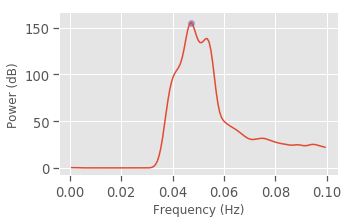

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,3))
ax.plot(f,fft)
loc = np.where(f==domFreq)[0][0]
ax.scatter(f[loc],fft[loc],color=sns.color_palette()[2])
#ax.set_xlim(0.02,0.1)
#ax.set_title('Power Spectral Density')
ax.set_ylabel('Power (dB)')
ax.set_xlabel('Frequency (Hz)');

In [10]:
window = int(fsEGG*60*4)
wSize = int(1/domFreq*fsEGG)
#wSize = 20
wNoise = 15000

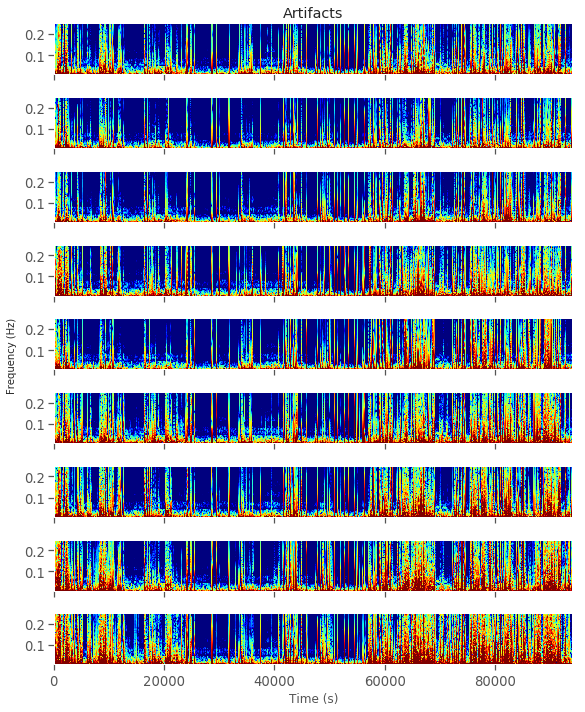

In [11]:
fig, ax = plt.subplots(nrows = dataEGG.shape[1], ncols = 1, figsize=(8,10), sharex=True)
cm = plt.cm.get_cmap('jet')
ax[0].set_title('Artifacts')
ax[dataEGG.shape[1]-1].set_xlabel('Time (s)')

artifact = []
for ii in range(0,dataEGG.shape[1]):
    wiener = sp.signal.wiener(dataEGG[:,ii], mysize=wSize, noise=wNoise)
    im = ax[ii].specgram(wiener,NFFT=window,Fs=fsEGG,noverlap=window*.75,interpolation='none')
    artifact.append(np.mean(im[0][im[1]>0.05,:],axis=0))
    ax[ii].axis('tight')
    ax[ii].set_ylim([0.01,0.25])
    #ax[ii].set_ylabel('Frequency (Hz)')
    ax[ii].grid(None)
    im[3].set_clim(20,55)

fig.text(-0.01, 0.5, 'Frequency (Hz)', va='center', rotation='vertical')
  
fig.tight_layout()
#cb = plt.colorbar(im[3],ax=ax[1])

In [12]:
for ii in range(0,dataEGG.shape[1]):
    if np.sum(dataEGG[:,ii])!=0:
        dataEGG[:,ii] = dataEGG[:,ii]-sp.signal.wiener(dataEGG[:,ii], mysize=wSize, noise=wNoise)

## Finding the "Best" Electrode Pair

In most electrophysiology recordings (e.g. EEG, EMG, etc), one electrode location is chosen as the reference location and the potentials at all the other electrode sites are recorded with respect to the reference by exploiting the properties of differential amplifiers.  This reference point is largely arbitrary.  We have the option of changing the effective reference to another recording site further down the processing chain by simple subtraction.  The original $N$-channel recording with respect to reference location $r$ yields the signals:

$$V_{n} - V_{r} \quad n = 1,N$$

We are free to re-reference to any one of the original recording sites $y$ by the transformation:

$$V_{n}-V_{y} \equiv \left(V_{n}-V_{r}\right) - \left(V_{y}-V_{r}\right) $$

where the potential difference inside the second parenthesis is obtained in the original recording.  This transformation can be applied to any recording location $y$ other than one with noisy data.

If there are $n$ channels that share the same reference, there are a total of ${n\choose 2}$ combinations of electrode pairs.  We will attempt at finding the "best" electrode pair for a given recording by iterating through every combination and assessing its quality.  A subject with normal stomach electrical activity should have a constant 3cpm (0.05Hz) throughout the recording.  If we assume the EGG data is from a normal subject, the pair with peak power of 2-4cpm (0.033-0.067Hz) during most of the recording should be the highest "quality".

In [13]:
# #band-pass filter
# b = signal.firwin(200,[0.015,0.16],nyq=0.5*fsEGG,window=('kaiser',6.0),pass_zero=False)
# dataEGG = signal.filtfilt(b,[1],x=dataEGG,axis=0)

In [14]:
iter = 0
spec,freqs,t = mlab.specgram(dataEGG[:,0]-0,NFFT=window,Fs=fsEGG,noverlap=window*.75)
percent3cpm = np.zeros(int(scipy.special.comb(dataEGG.shape[1],2)))
snr = np.zeros(int(scipy.special.comb(dataEGG.shape[1],2)))
power3cpm = np.zeros([int(scipy.special.comb(dataEGG.shape[1],2)),t.size])
pairs = np.zeros([int(scipy.special.comb(dataEGG.shape[1],2)),2],dtype=int)
from itertools import combinations
for pair in combinations(range(dataEGG.shape[1]),2):
    dataTest = dataEGG[:,pair[0]]-dataEGG[:,pair[1]]
    spec,freqs,t = mlab.specgram(dataTest,NFFT=window,Fs=fsEGG,noverlap=window*.75)
    spec = 10*np.log10(spec)
    ind = np.argmax(spec,axis=0)
    percent3cpm[iter] = ((0.033<freqs[ind])&(freqs[ind]<0.067)).sum()/np.size(t)
    power3cpm[iter] = np.max(spec[(domFreq-0.01<freqs)&(freqs<domFreq+0.01),:],axis=0)#-np.median(spec[((0.075<freqs)&(freqs<0.15)),:])
    f,fft = sp.signal.welch(dataTest,fs=fsEGG,window="hanning",nperseg=fsEGG*60*6,nfft=fsEGG*60*6*4,
                            detrend="linear",scaling='spectrum')
    snr[iter] = np.max(fft[(f>0.03)&(f<0.07)])#/np.min(fft[(f>0.03)&(f<0.07)])
    pairs[iter,:] = pair
    iter += 1

#select best pairs
numTopPairs = 6
ind = snr.argsort()[-numTopPairs:][::-1]

## STFT Spectrogram of Best Pairs

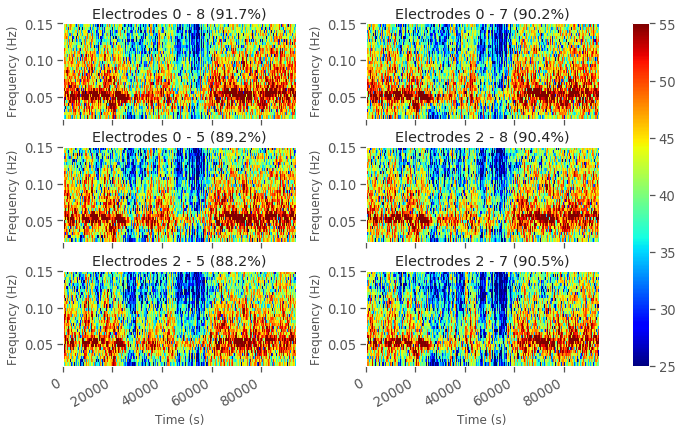

In [15]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(12,7))
fig.subplots_adjust(hspace=0.3,wspace=0.3)

iter=0
for ii in range(0,3):
    for jj in range(0,2):
        im = ax[ii,jj].specgram(dataEGG[:,pairs[ind[iter],0]]-dataEGG[:,pairs[ind[iter],1]],
                                NFFT=window,Fs=fsEGG,noverlap=window*.75,interpolation='none')
        ax[ii,jj].axis('tight')
        ax[ii,jj].set_ylim([0.02,0.15])
        ax[ii,jj].set_ylabel('Frequency (Hz)')
        ax[ii,jj].set_xlabel('Time (s)')
        ax[ii,jj].set_title("Electrodes %d - %d (%.1f%%)" % 
                            (pairs[ind[iter],0],pairs[ind[iter],1],percent3cpm[ind[iter]]*100))
        ax[ii,jj].grid(None)
        im[3].set_clim(25,55)
        fig.autofmt_xdate()
        iter+=1

cb = fig.colorbar(im[3], ax=ax.ravel().tolist())

## Summary Plots

### Calculate HR and HRV

Remove RR values and changes in RR that are not physiologically possible. Ref: Piskorski, Jarosław, and Przemysław Guzik. "Filtering poincare plots." Computational methods in science and technology 11.1 (2005): 39-48.


The root mean square of successive differences between NN intervals (RMSSD) parameter corresponds to parasympathetic activity. Normal range: 42 ± 15 ms, 19-75 ms. Ref: Nunan, David, Gavin RH Sandercock, and David A. Brodie. "A quantitative systematic review of normal values for short‐term heart rate variability in healthy adults." Pacing and clinical electrophysiology 33.11 (2010): 1407-1417.



In [16]:
RR = np.diff(rECG[0,:])*1000 #RR interval [ms]
tRR = rECG[0,1:] #corresponding time points of RR intervals [s]
RR = sp.signal.medfilt(RR,3) #median filter

#remove RR intervals that are not physiologically possible
stopCriteria = np.inf
while stopCriteria > 10: #loop until less than 10 RR intervals are removed
    removeRR = np.where((RR[1:]/RR[:-1]<=0.8) | (RR[1:]/RR[:-1]>=1.2) | 
                        (RR[:-1]/RR[1:]<=0.8) | (RR[:-1]/RR[1:]>=1.2) |
                        (RR[1:]>3000) | (RR[1:]<300))[0]
    RR = np.delete(RR,removeRR)
    tRR = np.delete(tRR,removeRR)
    stopCriteria = len(removeRR)
    
winHR = 5*60 #window size for calcluating HR parameters [s]
overlapHR = winHR*.8 #overlap between windows [s]
timeHR = np.arange(0,tRR[-1],winHR-overlapHR)[:-3]
HR = np.zeros(timeHR.size)
RMSSD = np.zeros(timeHR.size)
SDNN = np.zeros(timeHR.size)
for ii in range(0,timeHR.size):
    t1 = int(ii*(winHR-overlapHR))
    t2 = int((ii*(winHR-overlapHR)+winHR))
    HR[ii] = np.median(60/(RR[(tRR>t1)&(tRR<t2)]/1000))
    RMSSD[ii] = np.sqrt(np.mean(np.diff(RR[(tRR>t1)&(tRR<t2)])**2))
    SDNN[ii] = np.std(RR[(tRR>t1)&(tRR<t2)])
HR = gaussian_filter(HR,sigma=3)
RMSSD = gaussian_filter(RMSSD,sigma=3)
SDNN = gaussian_filter(SDNN,sigma=3)

In [17]:
# do now sympathovagal stuff
RRstuff  = np.copy(rECG)
RRintervals_seconds = np.diff(RRstuff[0,:])



# 4 minute windows for calculating sympathovagal ratio.  Can change this window length as we like
windowlength_sympathovagalratio_min = 4
windowlength_sympathovagalratio_seconds = 60*windowlength_sympathovagalratio_min
numWindows_sympathovagalratio=int(np.ceil(np.cumsum(RRintervals_seconds)[-1]/
                                          (windowlength_sympathovagalratio_seconds)))
# print('numWindows=',numWindows_sympathovagalratio)
sympathovagalratio = np.zeros((int(np.ceil(numWindows_sympathovagalratio)),))
cumsumRRintervals = np.cumsum(RRintervals_seconds)

# calculate sympathovagal ratio
for idx_window in range(sympathovagalratio.shape[0]):
#     print('window number=',idx_window)
    tmp = [(cumsumRRintervals[k] > idx_window*windowlength_sympathovagalratio_seconds) and 
           (cumsumRRintervals[k] < (idx_window+1)*windowlength_sympathovagalratio_seconds) for k in range(cumsumRRintervals.shape[0])]
    
    freqDomainFeats= frequencyDomain(RRintervals_seconds[tmp], plot = 0, title=None)
    sympathovagalratio[idx_window]=freqDomainFeats['LF/HF']


/opt/conda/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 94, using nperseg = 94
  .format(nperseg, input_length))


### Multi-Modal Plot

In [18]:
pltPair = pairs[ind[0]]

#artifacts
wiener = sp.signal.wiener(dataEGGRaw[:,pltPair[0]]-dataEGGRaw[:,pltPair[1]],
                          mysize=wSize, noise=wNoise)
spec,freqs,t = mlab.specgram(wiener,NFFT=window,Fs=fsEGG,noverlap=window*.75)
spec = 10*np.log10(spec)
artifact = (np.mean(spec[freqs>0.1,:],axis=0))
artifact = artifact>40

#extract EGG power
spec,freqs,t = mlab.specgram(dataEGG[:,pltPair[0]]-dataEGG[:,pltPair[1]],
                             NFFT=window,Fs=fsEGG,noverlap=window*.75)
delete = np.where(np.mean(spec,axis=0)<500)[0] #electrode not connected
spec = 10*np.log10(spec)
spec[np.isinf(spec)]=0 #when there are gaps in between recordings
powerEGG = np.max(spec[(domFreq-0.01<freqs)&(freqs<domFreq+0.01),:],axis=0)#-np.median(spec[(freqs>0.06)&(freqs<0.09),:])
powerEGG = signal.medfilt(powerEGG,15)
powerEGG = gaussian_filter(powerEGG,sigma=1)
baseline = np.percentile(spec[(freqs>domFreq+0.02),:].ravel(),98.5)+3
normPowerEGG = powerEGG-baseline#50
normPowerEGG[normPowerEGG<0] = 0
domFreqs = freqs[np.argmax(spec,axis=0)]
domFreqs[(normPowerEGG<2)|(domFreqs>domFreq+0.015)|(domFreqs<domFreq-0.015)|(artifact==True)]=np.nan

#### Format Variables in Date-Time

In [19]:
dtPowerEGG = pd.date_range(start=dtStart[0],periods=t.size,freq=str(int((t[1]-t[0])*1000))+'ms')
dtAccel = pd.date_range(start=dtStart[0],periods=dataAccel2.size,freq=str(int(1/fsAccel*1000))+'ms')
dtHR = pd.date_range(start=dtStart[0],periods=HR.size,freq=str(60000)+'ms')

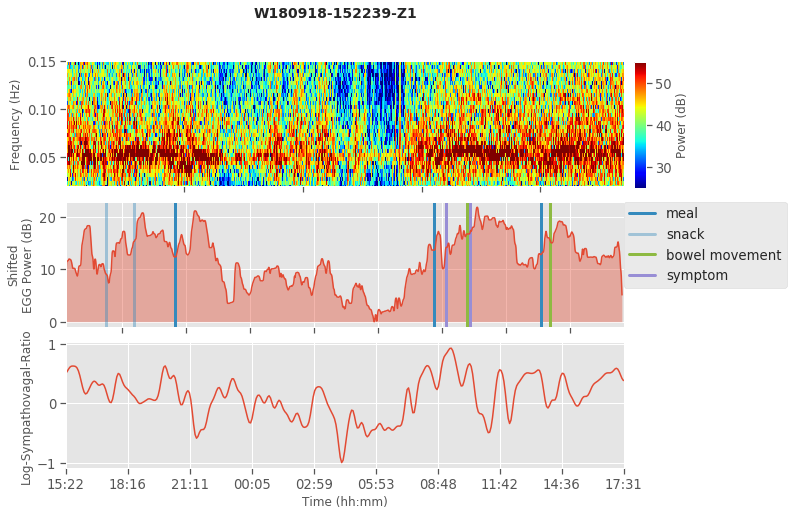

In [33]:
cm = plt.cm.get_cmap('jet')

# figsize=(width,height)
# fig = plt.figure(figsize=(10,5))
fig = plt.figure(figsize=(10,7.5))


fig.subplots_adjust(hspace=0.12)
plt.suptitle(RID,fontsize=14, fontweight='bold')
fig.tight_layout()

ax = plt.subplot(3,1,1)
s1 = ax.specgram(dataEGG[:,pltPair[0]]-dataEGG[:,pltPair[1]],
                 NFFT=window,Fs=fsEGG,noverlap=window*.75,interpolation='none',cmap=cm)
ax.axis('tight')
ax.set_ylim([0.02,0.15])
ax.set_ylabel('Frequency (Hz)')
ax.grid(False)
ax.axes.xaxis.set_ticklabels([])
s1[3].set_clim(25,55)
cbar_ax0 = fig.add_axes([.915, 0.644, 0.016, 0.66*0.355])
cb = plt.colorbar(s1[3],cax=cbar_ax0,ax=ax)
cb.set_label('Power (dB)')

#plot events
ax = plt.subplot(3,1,2)
# ax = plt.subplot(2,1,2)
[ax.axvline(dtEvents[np.where(eventType==3)][j],lw=3,color=sns.color_palette()[1],label='meal' if j==0 else "")
 for j in range(0,np.sum(eventType==3))]
[ax.axvline(dtEvents[np.where(eventType==4)][j],lw=3,alpha=0.4,color=sns.color_palette()[1],label='snack' if j==0 else "")
 for j in range(0,np.sum(eventType==4))]
[ax.axvline(dtEvents[np.where(eventType==5)][j],lw=3,color=sns.color_palette()[5],label='bowel movement' if j==0 else "")
 for j in range(0,np.sum(eventType==5))]
[ax.axvline(dtEvents[np.where(eventType==6)][j],lw=3,color=sns.color_palette()[2],label='symptom' if j==0 else "")
 for j in range(0,np.sum(eventType==6))]
ax.set_xlim([dtStart[0],dtStop[-1]])

ax.plot(dtPowerEGG,powerEGG-np.min(powerEGG))
ax.fill_between(dtPowerEGG,0,powerEGG-np.min(powerEGG),alpha=0.4)
# ax.plot(dtPowerEGG,normPowerEGG)
# ax.fill_between(dtPowerEGG,0,normPowerEGG,alpha=0.4)
# ax.set_ylabel('Normalized\nEGG Power (dB)')
ax.set_ylabel('Shifted\nEGG Power (dB)')
ax.legend(bbox_to_anchor=(1,1),loc=2,borderaxespad=0)
# ax.set_ylim([0,15])
ax.axes.xaxis.set_ticklabels([])

# plot sympathovagal ratio
ax = plt.subplot(3,1,3)


dtSympathovagalRatio = pd.date_range(start=dtStart[0],
                                     periods=sympathovagalratio.size,
                                     freq=str(int(1000*windowlength_sympathovagalratio_seconds))+'ms')

# changing the sympathovagal ratio changes the time interval for which you see this
# ax.plot(dtSympathovagalRatio,gaussian_filter(sympathovagalratio,sigma=2))
ax.plot(dtSympathovagalRatio,gaussian_filter(np.log(sympathovagalratio),sigma=2))
ax.set_ylabel('Log-Sympathovagal-Ratio')
ax.set_xlim([dtStart[0],dtStop[-1]])
ax.axes.xaxis.set_ticklabels([])


#ax.set_xticklabels(ax.xaxis.get_majorticklabels(),rotation=30,ha='right')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_ticks(pd.to_datetime(np.linspace(pd.Timestamp(dtStart[0]).value,pd.Timestamp(dtStop[-1]).value,10)))
ax.set_xlabel('Time (hh:mm)');



    

plt.savefig('./Results/'+RID_list[0]+'.png',dpi=100,bbox_inches='tight')

In [21]:
# sanity check
# print(dtStart[0],dtStop[-1])
# print(dtPowerEGG[0],dtPowerEGG[-1])
# print(dtSympathovagalRatio[0],dtSympathovagalRatio[-1])

2018-09-18 15:22:39 2018-09-19 17:31:04
2018-09-18 15:22:39 2018-09-19 17:26:39
2018-09-18 15:22:39 2018-09-19 17:30:39


### Features

#### Overall Analysis

Normal values of HRV: Nunan, David, Gavin R. H. Sandercock, and David A. Brodie. 2010. “A Quantitative Systematic Review of Normal Values for Short-Term Heart Rate Variability in Healthy Adults.” Pacing and Clinical Electrophysiology: PACE 33 (11): 1407–17.

In [22]:
#EGG Freatures
circFreq = (np.nanmean(domFreqs[(dtPowerEGG.hour>12)&(dtPowerEGG.hour<18)])-
            np.nanmean(domFreqs[(dtPowerEGG.hour>0)&(dtPowerEGG.hour<6)]))
#percentage of recording with normalized stomach activity over 3dB
percentStomachActivity = np.sum(normPowerEGG>0)/np.size(normPowerEGG)*100
#percentStomachActivity = np.sum(normPowerEGG[artifact==False]>3)/np.size(normPowerEGG[artifact==False])*100
percentArtifact = np.sum(artifact)/np.size(artifact)*100
    
#HR features
circHR = (np.nanmean(HR[(dtHR.hour>12)&(dtHR.hour<18)])-
          np.nanmean(HR[(dtHR.hour>0)&(dtHR.hour<6)]))
circRMSSD = (np.nanmean(RMSSD[(dtHR.hour>12)&(dtHR.hour<18)])-
             np.nanmean(RMSSD[(dtHR.hour>0)&(dtHR.hour<6)]))
circSDNN = (np.nanmean(SDNN[(dtHR.hour>12)&(dtHR.hour<18)])-
            np.nanmean(SDNN[(dtHR.hour>0)&(dtHR.hour<6)]))

recordingDuration = time.gmtime(dataEGG.shape[0]/fsEGG)
recordingDuration = (str((recordingDuration.tm_mday-1)*24+recordingDuration.tm_hour).zfill(2)+':'+
                     str(recordingDuration.tm_min).zfill(2)+':'+str(recordingDuration.tm_sec).zfill(2))

In [23]:
print('Recording Date:\t\t\t\t',dtStart[0].strftime('%d-%B-%Y'))
print('Recording Start Time (hh:mm:ss):\t',dtStart[0].strftime('%H:%M:%S'))
print('Recording Duration (hh:mm:ss):\t\t',recordingDuration) #or str(datetime.timedelta(seconds=dataEGG.shape[0]/fsEGG))
print('Number of Meals:\t\t\t',np.sum((dtEvents[eventType==3]>=dtStart[0])&(dtEvents[eventType==3]<=dtStop[-1])))
print('Number of Snacks:\t\t\t',np.sum(eventType==4))
print('Number of Bowel Movements:\t\t',np.sum(eventType==5))
print('Number of Symptoms:\t\t\t',np.sum(eventType==6))

print('\nGlobal Percent Stomach Activity:\t',np.round(percentStomachActivity,1),'%')
print('Global Percent Artifact:\t\t',np.round(percentArtifact,1),'%')
print('Mean EGG Frequency (Hz):\t\t',np.round(np.nanmean(domFreqs),4))
print('Mean Heart Rate (bpm):\t\t\t',np.round(np.nanmean(HR),1))
print('Mean SDNN (ms):\t\t\t\t',np.round(np.nanmean(SDNN),1),'\t\t\t','Normal Range: 32-93 ms')
print('Mean RMSSD (ms):\t\t\t',np.round(np.nanmean(RMSSD),1),'\t\t\t','Normal Range: 19-75 ms')

print('\nDay-Night Diff EGG Frequency (Hz):\t',np.round(circFreq,4))
print('Day-Night Diff Heart Rate (bpm):\t',np.round(circHR,1),)
print('Day-Night Diff SDNN (ms):\t\t',np.round(circRMSSD,1))
print('Day-Night Diff RMSSD (ms):\t\t',np.round(circSDNN,1))
print('')

Recording Date:				 18-September-2018
Recording Start Time (hh:mm:ss):	 15:22:39
Recording Duration (hh:mm:ss):		 26:08:25
Number of Meals:			 3
Number of Snacks:			 2
Number of Bowel Movements:		 2
Number of Symptoms:			 2

Global Percent Stomach Activity:	 71.1 %
Global Percent Artifact:		 18.5 %
Mean EGG Frequency (Hz):		 0.0495
Mean Heart Rate (bpm):			 72.8
Mean SDNN (ms):				 81.3 			 Normal Range: 32-93 ms
Mean RMSSD (ms):			 32.4 			 Normal Range: 19-75 ms

Day-Night Diff EGG Frequency (Hz):	 0.0023
Day-Night Diff Heart Rate (bpm):	 25.4
Day-Night Diff SDNN (ms):		 -7.2
Day-Night Diff RMSSD (ms):		 0.7



#### Meal Analysis

In [24]:
mealTimes = dtEvents[(eventType==3)&(dtEvents>dtStart[0])&((dtEvents<dtStop[-1]))]
dt = int((dtPowerEGG[1]-dtPowerEGG[0]).total_seconds())/60
tMeals = []
normPowerEGGMeals = []
timeSinceMeal = []
timeUntilMeal = []
mealAUC = []
preprandialEGG = np.zeros(len(mealTimes))
postprandialEGG = np.zeros(len(mealTimes))
timeToPeak = np.zeros(len(mealTimes))
for ii in range(0,len(mealTimes)):
    winPreprandial = np.where((dtPowerEGG>=mealTimes[ii]-np.timedelta64(1,'h'))&(dtPowerEGG<mealTimes[ii]))[0]
    winPostprandial = np.where((dtPowerEGG>=mealTimes[ii])&(dtPowerEGG<=mealTimes[ii]+np.timedelta64(4,'h')))[0]
    tMeals.append(np.concatenate([np.arange(-len(winPreprandial)*dt,0,dt),np.arange(0,len(winPostprandial)*dt,dt)]))
    normPowerEGGMeals.append(np.concatenate([normPowerEGG[winPreprandial],normPowerEGG[winPostprandial]]))

    #time since previous meal and until next meal
    index = np.where(dtEvents[(eventType==3)]==mealTimes[ii])[0][0]
    if index==0: timeSinceMeal.append(np.nan)
    if index>0:
        timeSinceMeal.append((dtEvents[(eventType==3)][index]-dtEvents[(eventType==3)][index-1]).total_seconds())
    if len(dtEvents[(eventType==3)])-1>index:
        timeUntilMeal.append((dtEvents[(eventType==3)][index+1]-dtEvents[(eventType==3)][index]).total_seconds())
    if len(dtEvents[(eventType==3)])-1==index: timeUntilMeal.append(np.nan)
        
    #area under the curve
    mealAUC.append(np.zeros(5))
    for jj in range(0,5):
        winEGG = normPowerEGG[(dtPowerEGG>=mealTimes[ii]-np.timedelta64(1,'h')+np.timedelta64(jj,'h'))&
                              (dtPowerEGG<=mealTimes[ii]-np.timedelta64(1,'h')+np.timedelta64(jj+1,'h'))]
        if len(winEGG)*dt>49: #at least 50 min of data in 1hr window
            mealAUC[ii][jj] = np.trapz(winEGG,dx=dt)
        else: mealAUC[ii][jj] = np.nan
            
    #mean preprandial and postprandial power
    preprandialEGG[ii] = np.mean(normPowerEGG[(dtPowerEGG>=mealTimes[ii]-np.timedelta64(1,'h'))&(dtPowerEGG<mealTimes[ii])])
    postprandialEGG[ii] = np.mean(normPowerEGG[(dtPowerEGG>=mealTimes[ii])&(dtPowerEGG<=mealTimes[ii]+np.timedelta64(4,'h'))])
    
    #time to peak postprandial power
    timeToPeak[ii] = tMeals[ii][tMeals[ii]>0][np.argmax(normPowerEGGMeals[ii][tMeals[ii]>0])]/60

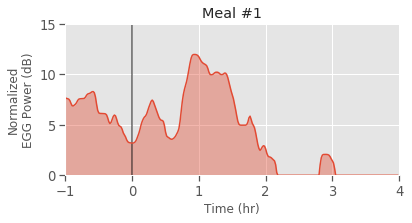

Time Reported (hh:mm):			 20:30
Subject Note:				 chicken sausage, veggies, cheese
Time Since Last Reported Meal (hrs):	 7.2
Time Until Next Reported Meal (hrs):	 12.1

Pre-prandial EGG AUC (-1hr) (dB-min):	 373.7
Post-prandial EGG AUC (1hr) (dB-min):	 375.4
Post-prandial EGG AUC (2hr) (dB-min):	 820.7
Post-prandial EGG AUC (4hr) (dB-min):	 859.8

Pre-prandial  Mean EGG Power (dB):	 6.3
Post-prandial Mean EGG Power (dB):	 3.7
Post-prandial EGG Power Change (dB):	 -2.6
Post-prandial Time to Peak Power (hrs):	 0.9



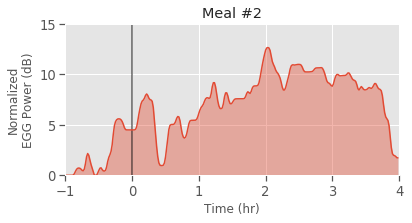

Time Reported (hh:mm):			 08:37
Subject Note:				 cereal with milk
Time Since Last Reported Meal (hrs):	 12.1
Time Until Next Reported Meal (hrs):	 5.0

Pre-prandial EGG AUC (-1hr) (dB-min):	 113.6
Post-prandial EGG AUC (1hr) (dB-min):	 290.3
Post-prandial EGG AUC (2hr) (dB-min):	 762.8
Post-prandial EGG AUC (4hr) (dB-min):	 1846.1

Pre-prandial  Mean EGG Power (dB):	 1.9
Post-prandial Mean EGG Power (dB):	 7.8
Post-prandial EGG Power Change (dB):	 5.9
Post-prandial Time to Peak Power (hrs):	 2.0



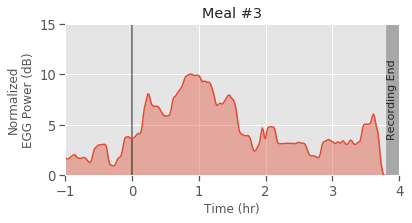

Time Reported (hh:mm):			 13:38
Subject Note:				 Chicken
Time Since Last Reported Meal (hrs):	 5.0
Time Until Next Reported Meal (hrs):	 next meal not reported

Pre-prandial EGG AUC (-1hr) (dB-min):	 126.4
Post-prandial EGG AUC (1hr) (dB-min):	 426.0
Post-prandial EGG AUC (2hr) (dB-min):	 793.7
Post-prandial EGG AUC (4hr) (dB-min):	 nan

Pre-prandial  Mean EGG Power (dB):	 2.2
Post-prandial Mean EGG Power (dB):	 5.1
Post-prandial EGG Power Change (dB):	 2.9
Post-prandial Time to Peak Power (hrs):	 0.9



In [25]:
for ii in range(0,len(mealTimes)):
    fig, ax = plt.subplots(figsize=(6,3.2))
    ax.axvline(0,color='black',alpha=0.6)
    ax.plot(tMeals[ii]/60,normPowerEGGMeals[ii])
    ax.fill_between(tMeals[ii]/60,0,normPowerEGGMeals[ii],alpha=0.4)
    ax.set_xlabel('Time (hr)')
    ax.set_ylabel('Normalized\nEGG Power (dB)')
    ax.set_xlim([-1,4])
    ax.set_ylim([0,15])
    ax.set_title('Meal #'+str(ii+1))
    if tMeals[ii][0]>-49:
        ax.axvspan(-60,tMeals[ii][0]/60,color='grey',alpha=0.6)
        ax.text((tMeals[ii][0]-6)/60,7.5,'Recording Start',rotation=90,fontsize=11,
                horizontalalignment='center',verticalalignment='center')
    if tMeals[ii][-1]<229:
        ax.axvspan(tMeals[ii][-1]/60,4,color='grey',alpha=0.6)
        ax.text((tMeals[ii][-1]+6)/60,7.5,'Recording End',rotation=90,fontsize=11,
                horizontalalignment='center',verticalalignment='center')
    fig.tight_layout()
    plt.show()
    
    print('Time Reported (hh:mm):\t\t\t',(str(mealTimes[ii].hour).zfill(2)+':'+str(mealTimes[ii].minute).zfill(2)))
    print('Subject Note:\t\t\t\t',eventTable['Notes'][np.where(eventTable['Timestamp']==str(mealTimes[ii]))[0][0]])
    if np.isnan(timeSinceMeal[ii])==True: print('Time Since Last Reported Meal (hrs):\t','last meal not reported')
    else: print('Time Since Last Reported Meal (hrs):\t',np.round(timeSinceMeal[ii]/3600,1))
    if np.isnan(timeUntilMeal[ii])==True: print('Time Until Next Reported Meal (hrs):\t','next meal not reported')
    else: print('Time Until Next Reported Meal (hrs):\t',np.round(timeUntilMeal[ii]/3600,1))
    print('\nPre-prandial EGG AUC (-1hr) (dB-min):\t',np.round(mealAUC[ii][0],1))
    print('Post-prandial EGG AUC (1hr) (dB-min):\t',np.round(mealAUC[ii][1],1))
    print('Post-prandial EGG AUC (2hr) (dB-min):\t',np.round(mealAUC[ii][1]+mealAUC[ii][2],1))
    print('Post-prandial EGG AUC (4hr) (dB-min):\t',np.round(mealAUC[ii][1]+mealAUC[ii][2]+mealAUC[ii][3]+mealAUC[ii][4],1))
    print('\nPre-prandial  Mean EGG Power (dB):\t',np.round(preprandialEGG[ii],1))
    print('Post-prandial Mean EGG Power (dB):\t',np.round(postprandialEGG[ii],1))
    print('Post-prandial EGG Power Change (dB):\t',np.round(np.round(postprandialEGG[ii],1)-np.round(preprandialEGG[ii],1),1))
    print('Post-prandial Time to Peak Power (hrs):\t',np.round(timeToPeak[ii],1))
    print('')

#### Symptom Association Analysis

In [26]:
print('\nSymptom Association Analysis:\n')

symptomTimes = dtEvents[eventType==6]
if len(symptomTimes)>0:
    symptomEGGActivity = np.zeros(len(symptomTimes))
    symptomAUC = np.zeros(len(symptomTimes))
    for ii in range(0,len(symptomTimes)):
        winEGG = normPowerEGG[(dtPowerEGG<=symptomTimes[ii]+np.timedelta64(30,'m'))&(dtPowerEGG>=symptomTimes[ii]-np.timedelta64(10,'m'))]
        symptomEGGActivity[ii] = np.mean(winEGG)
        if len(winEGG)*dt>30: #at least 30 min of data in 40 min window
            symptomAUC[ii] = np.trapz(winEGG,dx=dt)
        print('Reported Symptom #',ii+1)
        print('Time Reported (hh:mm):\t\t\t',(str(symptomTimes[ii].hour).zfill(2)+':'+str(symptomTimes[ii].minute).zfill(2)))
        print('Subject Note:\t\t\t\t',eventTable['Notes'][np.where(eventTable['Timestamp']==str(symptomTimes[ii]))[0][0]])
        print('Mean EGG Power (-10 to +30 min) (dB):\t',np.round(symptomEGGActivity[ii],1))
        print('EGG AUC (-10 to +30 min) (dB-min):\t',np.round(symptomAUC[ii],1))
        print('')
else:
    print('No symptoms reported on diary during the study period.\n')
print('')


Symptom Association Analysis:

Reported Symptom # 1
Time Reported (hh:mm):			 09:11
Subject Note:				 took medicine (synthroid, minocycline) very small amount of reflux
Mean EGG Power (-10 to +30 min) (dB):	 4.4
EGG AUC (-10 to +30 min) (dB-min):	 172.5

Reported Symptom # 2
Time Reported (hh:mm):			 10:20
Subject Note:				 constipation, nausea (took zofran)
Mean EGG Power (-10 to +30 min) (dB):	 9.5
EGG AUC (-10 to +30 min) (dB-min):	 373.2




In [27]:
# you need to create a "Results/" directory in the same directory where this notebook is running.  Or you can just 
dfEGG = pd.DataFrame(data={'Raw EGG Power (dB)':powerEGG,
                           'Normalized EGG Power (dB)':normPowerEGG,
                           'Artifact':artifact,
                           'EGG Frequency (Hz)':domFreqs},index = dtPowerEGG)
dfEGG = dfEGG.round({'Normalized EGG Power (dB)': 2,'Raw EGG Power (dB)': 2,'EGG Frequency (Hz)': 3})
dfEGG = dfEGG.fillna('')
dfEGG.index.name = 'Timestamp'
dfEGG.to_csv('./Results/'+RID+'-EGG.csv',sep=',')

dfSympathovagalRatio = pd.DataFrame(data={'sympathovagalratio': sympathovagalratio},index=dtSympathovagalRatio)
dfSympathovagalRatio.index.name = 'Timestamp'
dfSympathovagalRatio.to_csv('./Results/'+RID+'-sympathovagal.csv',sep=',')

dfACC = pd.DataFrame(data={'AccX':dataAccel[:,0],'AccY':dataAccel[:,1],'AccZ':dataAccel[:,2]},
                  index = dtAccel)
dfACC = dfACC.round(decimals=2)
dfACC.index.name = 'Timestamp'
dfACC.to_csv('./Results/'+RID+'-ACC.csv',sep=',')

dfHR = pd.DataFrame(data={'HR (bpm)':HR,'RMSSD (ms)':RMSSD,'SDNN (ms)':SDNN},index = dtHR)
dfHR = dfHR.round(decimals=1)
dfHR.index.name = 'Timestamp'
dfHR.to_csv('./Results/'+RID+'-HR.csv',sep=',')

eventTable.to_csv('./Results/'+RID_list[0]+'-events.csv',sep=',')